In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [418]:
torch.__version__

'2.3.0+cpu'

In [419]:
# constants
INPUT_SHAPE = 8
HIDDEN_UNITS = 64
NUM_EPOCHS = 400
WEIGHT_DECAY = 1e-3
DROPOUT_RATE = 0.60

In [420]:
# Read CSV file into a DataFrame
dataset = pd.read_csv('UCI_Heart_Disease_Dataset_Combined.csv')

# Extract features and labels from DataFrame
X = dataset.iloc[:, :-1].values  # Assuming the features are in the first columns
y = dataset.iloc[:, -1].values   # Assuming the labels are in the last column

In [421]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [422]:
from sklearn.decomposition import PCA
pca = PCA(n_components=INPUT_SHAPE)
X_pca = pca.fit_transform(X)
X_pca.shape

(2943, 8)

In [423]:
temp_df = pd.DataFrame(X)
temp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.0,0.0,0.0,40.0,1.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0
1,0.0,0.0,1.0,0.0,49.0,0.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0
2,0.0,1.0,0.0,0.0,37.0,1.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0
3,0.0,0.0,0.0,1.0,48.0,0.0,138.0,214.0,0.0,0.0,108.0,1.0,1.5
4,0.0,0.0,1.0,0.0,54.0,1.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,0.0,1.0,0.0,0.0,59.0,1.0,140.0,221.0,0.0,1.0,164.0,1.0,0.0
2939,1.0,0.0,0.0,0.0,60.0,1.0,125.0,258.0,0.0,0.0,141.0,1.0,2.8
2940,1.0,0.0,0.0,0.0,47.0,1.0,110.0,275.0,0.0,0.0,118.0,1.0,1.0
2941,1.0,0.0,0.0,0.0,50.0,0.0,110.0,254.0,0.0,0.0,159.0,0.0,0.0


In [424]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)

In [425]:
# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [426]:
X_train, X_test

(array([[-2.96054117e-01, -1.63439365e-02,  1.53544963e+00, ...,
          9.45465777e-01, -4.41144114e-01,  7.23676031e-01],
        [-1.93461188e-01, -1.37378618e-01,  1.22449901e+00, ...,
          5.65216823e-01,  1.00980930e+00, -2.64245198e-01],
        [-2.27586592e+00,  1.99445072e+00,  2.26331237e-01, ...,
         -2.43954229e-01, -9.40429359e-01,  8.62753033e-02],
        ...,
        [ 2.00719937e+00, -3.17240084e-01, -1.64208765e+00, ...,
         -1.23427981e+00, -8.48648986e-01, -4.36474144e-01],
        [ 4.09398088e-01,  5.24323909e-01, -2.05275046e+00, ...,
          1.67299567e+00, -1.65163055e-01, -1.12285876e+00],
        [-6.53259665e-03,  3.13484120e-02,  3.48195130e-01, ...,
         -8.28573994e-01,  1.13536939e-03,  2.04242962e+00]]),
 array([[-0.45075435,  0.33089549,  0.04677221, ..., -0.67163577,
         -0.70704364, -0.65201504],
        [-0.19979973,  0.88614286, -1.21530468, ..., -0.61275994,
         -1.31372545,  0.91978536],
        [ 1.3729081 , -0.

In [427]:
# Convert Numpy arrays back to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)  # Assuming labels are integers
y_test = torch.tensor(y_test, dtype=torch.float32)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([2354, 8])
X_test shape: torch.Size([589, 8])
y_train shape: torch.Size([2354])
y_test shape: torch.Size([589])


In [428]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [429]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V0(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.classification = nn.Sequential(
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_0 = Classification_V0(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1).to(device)
model_0

Classification_V0(
  (classification): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [430]:
# loss_fn for all models
loss_fn = nn.BCEWithLogitsLoss()

In [431]:
def get_optimizer(model):
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=WEIGHT_DECAY, lr=0.001)
    return optimizer

In [432]:
optimizer = get_optimizer(model_0)

In [433]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [434]:
def train_step(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module, 
               X_train: torch.Tensor,
               y_train: torch.Tensor,
               device=device):
  
  X_train = X_train.to(device)
  y_train = y_train.to(device)
    ### Training
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()

  # turn logits -> pred props -> pred labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss

  # nn.BCELoss expects prediction probabilities as input
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)

  # nn.BCEWithLogistLoss expects raw logits as input (we will use this)
  loss = loss_fn(y_logits, y_train)

  # Calculate the accuracy
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  return loss.item(), acc

In [435]:
def test_step(model: torch.nn.Module, 
                loss_fn: torch.nn.Module,
                X_test: torch.Tensor,
                y_test: torch.Tensor,
                device=device):
    
    X_test = X_test.to(device)
    y_test= y_test.to(device)
    
    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
    
    return test_loss.item(), test_acc

In [436]:
def train_model(model:torch.nn.Module, 
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module, 
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_test: torch.Tensor,
                y_test: torch.Tensor,
                epochs:int,
                seed: int = None,
                device=device):
  
  if seed:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Build training and evaluation loop
  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model, 
                                       optimizer=optimizer, 
                                       loss_fn=loss_fn, 
                                       X_train=X_train, 
                                       y_train=y_train, 
                                       device=device
                                       )
    
    test_loss, test_acc = test_step(model=model, 
                                      loss_fn=loss_fn, 
                                      X_test=X_test, 
                                      y_test=y_test, 
                                      device=device
                                      )

    ### Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {train_loss: .5f} | Acc: {train_acc: .2f}% | Test Loss: {test_loss: .5f} | Test Acc: {test_acc: .2f}%")
      # 5. Update results dictionary
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
  return results

In [437]:
model_0_results = train_model(model=model_0, 
            optimizer=optimizer, 
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.74211 | Acc:  40.61% | Test Loss:  0.73591 | Test Acc:  42.11%
Epoch: 10 | Loss:  0.68813 | Acc:  53.95% | Test Loss:  0.68269 | Test Acc:  54.16%
Epoch: 20 | Loss:  0.64564 | Acc:  63.89% | Test Loss:  0.64089 | Test Acc:  63.50%
Epoch: 30 | Loss:  0.61258 | Acc:  69.07% | Test Loss:  0.60856 | Test Acc:  69.10%
Epoch: 40 | Loss:  0.58780 | Acc:  71.92% | Test Loss:  0.58481 | Test Acc:  71.48%
Epoch: 50 | Loss:  0.57060 | Acc:  73.07% | Test Loss:  0.56862 | Test Acc:  73.68%
Epoch: 60 | Loss:  0.55990 | Acc:  74.09% | Test Loss:  0.55840 | Test Acc:  74.19%
Epoch: 70 | Loss:  0.55407 | Acc:  74.51% | Test Loss:  0.55227 | Test Acc:  73.68%
Epoch: 80 | Loss:  0.55136 | Acc:  74.51% | Test Loss:  0.54870 | Test Acc:  74.36%
Epoch: 90 | Loss:  0.55031 | Acc:  74.34% | Test Loss:  0.54667 | Test Acc:  74.36%
Epoch: 100 | Loss:  0.55001 | Acc:  74.09% | Test Loss:  0.54560 | Test Acc:  74.36%
Epoch: 110 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54514 | Test Acc:

Epoch: 200 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54524 | Test Acc:  74.19%
Epoch: 210 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54524 | Test Acc:  74.19%
Epoch: 220 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54524 | Test Acc:  74.19%
Epoch: 230 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54524 | Test Acc:  74.19%
Epoch: 240 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54524 | Test Acc:  74.19%
Epoch: 250 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54525 | Test Acc:  74.19%
Epoch: 260 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54525 | Test Acc:  74.19%
Epoch: 270 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54525 | Test Acc:  74.19%
Epoch: 280 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54525 | Test Acc:  74.19%
Epoch: 290 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54525 | Test Acc:  74.19%
Epoch: 300 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54526 | Test Acc:  74.19%
Epoch: 310 | Loss:  0.54994 | Acc:  74.09% | Test Loss:  0.54526 

In [438]:
from typing import List, Dict
def plot_loss_curves(results: Dict[str, List[float]], model_name: str):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Set up a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title(model_name + " Loss")
    plt.xlabel("Epochs")
    plt.ylim(0, 1.0)  # Set y-axis limits from 0 to 1.0
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title(model_name + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylim(0, 100)
    plt.legend()

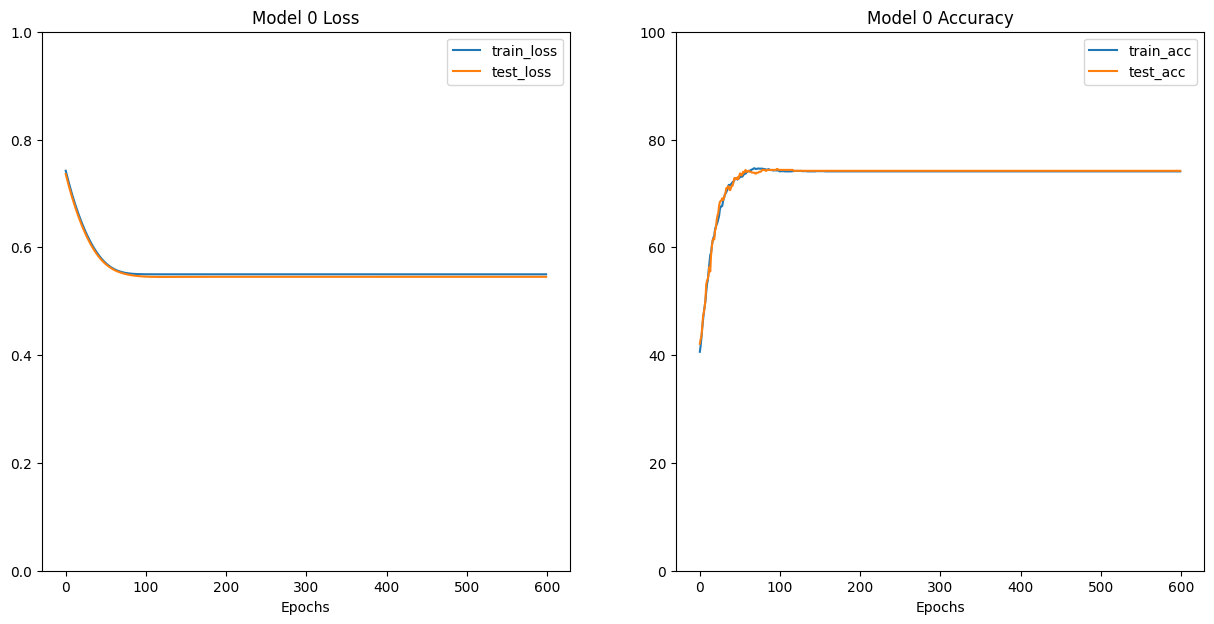

In [439]:
plot_loss_curves(model_0_results, model_name="Model 0")

In [440]:
# 1. Contruct a baseline model to check if forward pass works
class Classification_V2_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_2_dropout = Classification_V2_Dropout(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1, 
                            dropout_rate=DROPOUT_RATE).to(device)
model_2_dropout

Classification_V2_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [441]:
optimizer = get_optimizer(model_2_dropout)

In [442]:
model_2_dropout_results = train_model(model=model_2_dropout, 
            optimizer=optimizer, 
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.69589 | Acc:  46.60% | Test Loss:  0.69270 | Test Acc:  49.75%
Epoch: 10 | Loss:  0.66728 | Acc:  63.72% | Test Loss:  0.65916 | Test Acc:  68.59%
Epoch: 20 | Loss:  0.62346 | Acc:  69.33% | Test Loss:  0.60110 | Test Acc:  75.21%
Epoch: 30 | Loss:  0.57570 | Acc:  71.41% | Test Loss:  0.53898 | Test Acc:  74.53%
Epoch: 40 | Loss:  0.55894 | Acc:  72.56% | Test Loss:  0.51882 | Test Acc:  75.04%
Epoch: 50 | Loss:  0.54235 | Acc:  72.51% | Test Loss:  0.51173 | Test Acc:  75.21%
Epoch: 60 | Loss:  0.53113 | Acc:  74.30% | Test Loss:  0.50348 | Test Acc:  75.89%
Epoch: 70 | Loss:  0.52705 | Acc:  74.30% | Test Loss:  0.49384 | Test Acc:  76.23%
Epoch: 80 | Loss:  0.52625 | Acc:  73.96% | Test Loss:  0.48846 | Test Acc:  76.40%
Epoch: 90 | Loss:  0.51577 | Acc:  74.98% | Test Loss:  0.48551 | Test Acc:  77.08%
Epoch: 100 | Loss:  0.50535 | Acc:  74.26% | Test Loss:  0.48176 | Test Acc:  77.59%
Epoch: 110 | Loss:  0.49725 | Acc:  74.98% | Test Loss:  0.47784 | Test Acc:

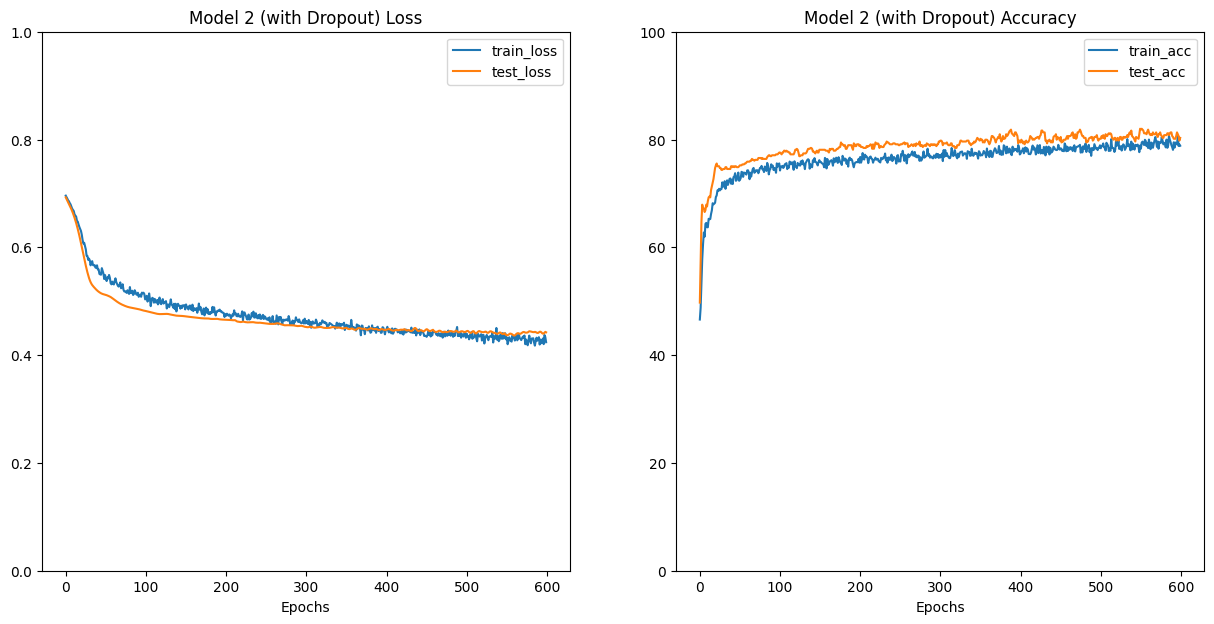

In [443]:
plot_loss_curves(model_2_dropout_results, model_name="Model 2 (with Dropout)")

In [452]:
# Slighly less complex model
class Classification_V5_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 2, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_5_dropout = Classification_V5_Dropout(input_shape=INPUT_SHAPE, 
                                            hidden_units=HIDDEN_UNITS, 
                                            output_shape=1, 
                                            dropout_rate=DROPOUT_RATE).to(device)
model_5_dropout

Classification_V5_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [453]:
optimizer = get_optimizer(model_5_dropout)

In [454]:
model_5_dropout_results = train_model(model=model_5_dropout, 
            optimizer=optimizer, 
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.72239 | Acc:  47.49% | Test Loss:  0.71374 | Test Acc:  45.33%
Epoch: 10 | Loss:  0.68211 | Acc:  56.03% | Test Loss:  0.66876 | Test Acc:  57.39%
Epoch: 20 | Loss:  0.65131 | Acc:  61.60% | Test Loss:  0.63489 | Test Acc:  68.59%
Epoch: 30 | Loss:  0.61957 | Acc:  68.31% | Test Loss:  0.60823 | Test Acc:  72.50%
Epoch: 40 | Loss:  0.59332 | Acc:  71.24% | Test Loss:  0.58664 | Test Acc:  73.17%
Epoch: 50 | Loss:  0.57552 | Acc:  72.30% | Test Loss:  0.56937 | Test Acc:  73.68%
Epoch: 60 | Loss:  0.56205 | Acc:  72.94% | Test Loss:  0.55585 | Test Acc:  74.02%
Epoch: 70 | Loss:  0.56810 | Acc:  72.13% | Test Loss:  0.54562 | Test Acc:  74.53%
Epoch: 80 | Loss:  0.54983 | Acc:  73.07% | Test Loss:  0.53800 | Test Acc:  74.70%
Epoch: 90 | Loss:  0.54081 | Acc:  73.58% | Test Loss:  0.53199 | Test Acc:  74.87%
Epoch: 100 | Loss:  0.52996 | Acc:  73.79% | Test Loss:  0.52676 | Test Acc:  75.89%
Epoch: 110 | Loss:  0.53539 | Acc:  74.72% | Test Loss:  0.52241 | Test Acc:

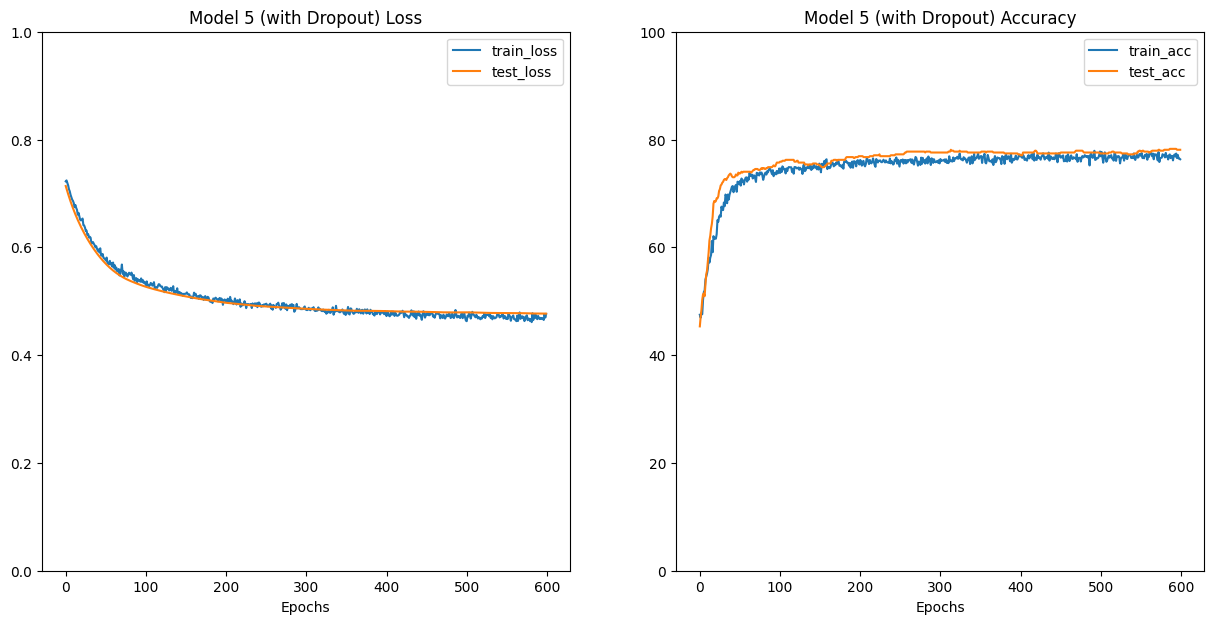

In [455]:
plot_loss_curves(model_5_dropout_results, model_name="Model 5 (with Dropout)")

In [448]:
# ascending hidden units this time
class Classification_V6_Dropout(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int, 
               dropout_rate: float):
    super().__init__()
    self.classification = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 2, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 8),
        nn.ReLU(),
        nn.Dropout(dropout_rate), 
        nn.Linear(in_features=hidden_units * 8, out_features=output_shape)
    )

  def forward(self, x):
    return self.classification(x)

# instantiante model
model_6_dropout = Classification_V6_Dropout(input_shape=INPUT_SHAPE, 
                            hidden_units=HIDDEN_UNITS, 
                            output_shape=1, 
                            dropout_rate=DROPOUT_RATE).to(device)
model_6_dropout

Classification_V6_Dropout(
  (classification): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [449]:
optimizer = get_optimizer(model_6_dropout)

In [450]:
model_6_dropout_results = train_model(model=model_6_dropout, 
            optimizer=optimizer, 
            loss_fn=loss_fn, 
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=NUM_EPOCHS,
            seed=42,
            device=device)

Epoch: 0 | Loss:  0.69528 | Acc:  50.34% | Test Loss:  0.68393 | Test Acc:  55.35%
Epoch: 10 | Loss:  0.61413 | Acc:  68.73% | Test Loss:  0.58005 | Test Acc:  73.51%
Epoch: 20 | Loss:  0.58044 | Acc:  71.50% | Test Loss:  0.52572 | Test Acc:  75.21%
Epoch: 30 | Loss:  0.54860 | Acc:  73.11% | Test Loss:  0.51557 | Test Acc:  76.57%
Epoch: 40 | Loss:  0.53308 | Acc:  72.68% | Test Loss:  0.49575 | Test Acc:  77.25%
Epoch: 50 | Loss:  0.52494 | Acc:  74.60% | Test Loss:  0.48916 | Test Acc:  77.93%
Epoch: 60 | Loss:  0.51020 | Acc:  74.72% | Test Loss:  0.48574 | Test Acc:  78.10%
Epoch: 70 | Loss:  0.50179 | Acc:  74.94% | Test Loss:  0.48107 | Test Acc:  78.61%
Epoch: 80 | Loss:  0.50466 | Acc:  75.28% | Test Loss:  0.48013 | Test Acc:  78.27%
Epoch: 90 | Loss:  0.50287 | Acc:  75.36% | Test Loss:  0.47839 | Test Acc:  79.46%
Epoch: 100 | Loss:  0.49836 | Acc:  76.30% | Test Loss:  0.47562 | Test Acc:  79.46%
Epoch: 110 | Loss:  0.49371 | Acc:  76.38% | Test Loss:  0.47282 | Test Acc:

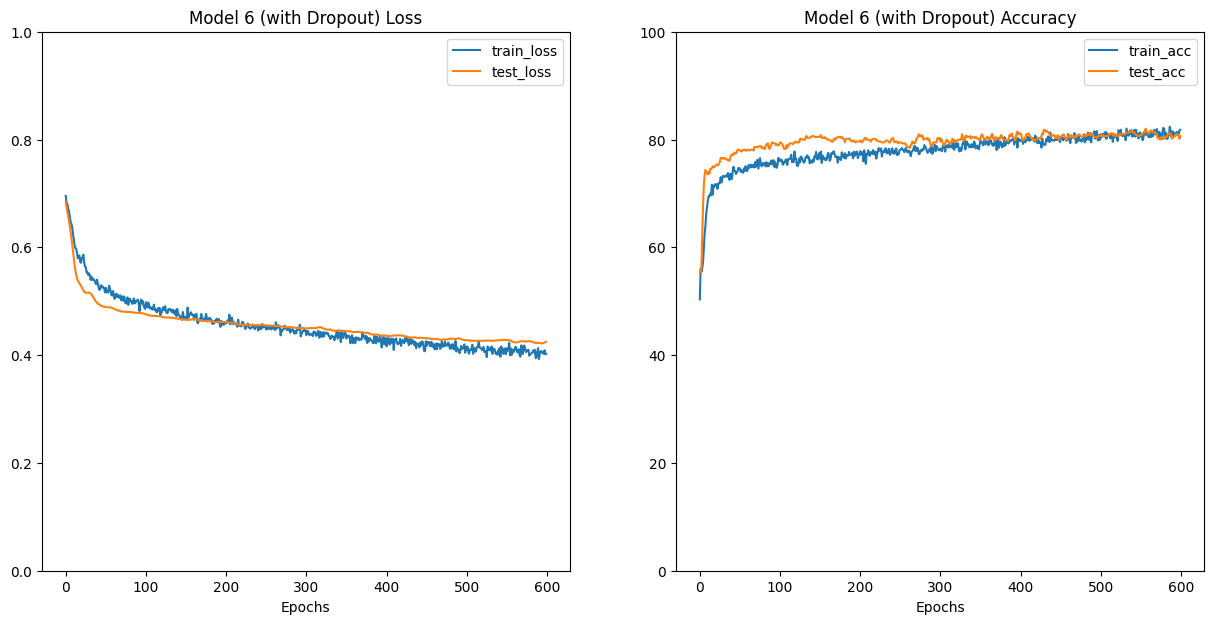

In [451]:
plot_loss_curves(model_6_dropout_results, model_name="Model 6 (with Dropout)")